# Homework part I

The first problem set contains basic tasks in PyTorch.

__Note:__ Instead of doing this part of homework, you can prove your skills otherwise:
* A commit to PyTorch or PyTorch-based repos will do;
* Fully implemented seminar assignment in tensorflow or theano will do;
* Your own project in PyTorch that is developed to a state in which a normal human can understand and appreciate what it does.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch, torch.nn as nn
import torch.nn.functional as F
print(torch.__version__)

1.12.1+cu113


### Task I - tensormancy

![img](https://media.giphy.com/media/3o751UMCYtSrRAFRFC/giphy.gif)

When dealing with more complex stuff like neural network, it's best if you use tensors the way samurai uses his sword. 


__1.1 The Cannabola__
[(_disclaimer_)](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

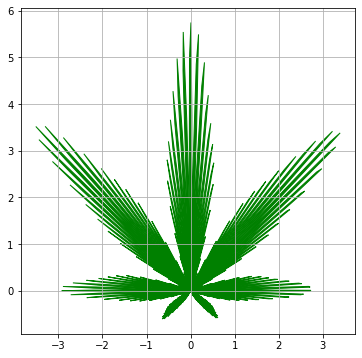

In [2]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1+ 0.9 * torch.cos(8*theta))*(1+ 0.1 * torch.cos(24 * theta)) * (0.9 +0.5 *torch.cos(200*theta)) * (1+ torch.sin(theta))   ### YOUR CODE

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x =  rho *  torch.cos(theta)         ### YOUR CODE
y =  rho *  torch.sin(theta)         ### YOUR CODE


plt.figure(figsize=[6, 6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

### Task II: The Game of Life

Now it's time for you to make something more challenging. We'll implement Conway's [Game of Life](http://web.stanford.edu/~cdebs/GameOfLife/) in _pure PyTorch_.

While this is still a toy task, implementing game of life this way has one cool benefit: __you'll be able to run it on GPU!__ Indeed, what could be a better use of your GPU than simulating Game of Life on 1M/1M grids?

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)
If you've skipped the URL above out of sloth, here's the Game of Life:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* Any living cell that has 2 or 3 neighbors survives, else it dies [0,1 or 4+ neighbors]
* Any cell with exactly 3 neighbors becomes alive (if it was dead)

For this task, you are given a reference NumPy implementation that you must convert to PyTorch.
_[NumPy code inspired by: https://github.com/rougier/numpy-100]_


__Note:__ You can find convolution in `torch.nn.functional.conv2d(Z,filters)`. Note that it has a different input format.

__Note 2:__ From the mathematical standpoint, PyTorch convolution is actually cross-correlation. Those two are very similar operations. More info: [video tutorial](https://www.youtube.com/watch?v=C3EEy8adxvc), [scipy functions review](http://programmerz.ru/questions/26903/2d-convolution-in-python-similar-to-matlabs-conv2-question), [stack overflow source](https://stackoverflow.com/questions/31139977/comparing-matlabs-conv2-with-scipys-convolve2d).

In [17]:
from scipy.signal import correlate2d

def np_update(Z):
    # Count neighbours with convolution
    filters = np.array([[1, 1, 1],
                        [1, 0, 1],
                        [1, 1, 1]])

    N = correlate2d(Z, filters, mode='same')

    # Apply rules
    birth = (N == 3) & (Z == 0)
    survive = ((N == 2) | (N == 3)) & (Z == 1)

    Z[:] = birth | survive
    return Z

In [24]:
def torch_update(Z):
    """
    Implement an update function that does to Z exactly the same as np_update.
    :param Z: torch.FloatTensor of shape [height,width] containing 0s(dead) an 1s(alive)
    :returns: torch.FloatTensor Z after updates.
    
    You can opt to create new tensor or change Z inplace.
    """
    filters = torch.tensor([[[[1.0, 1.0, 1.0],
                        [1.0, 0.0, 1.0],
                        [1.0, 1.0, 1.0]]]])
    Z_copy = Z[None , None , :] 
    N = torch.nn.functional.conv2d(Z_copy,filters, padding='same')

    # Apply rules
    birth = (N == 3) & (Z_copy == 0)
    survive = ((N == 2) | (N == 3)) & (Z_copy == 1)

    Z_copy[:] = birth | survive
    #<Your code here!>
    
    return Z_copy[0,0]


In [25]:
# initial frame
Z_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
Z = torch.from_numpy(Z_numpy).type(torch.FloatTensor)

# your debug polygon :)
Z_new = torch_update(Z.clone())

# tests
Z_reference = np_update(Z_numpy.copy())
assert np.all(Z_new.numpy() == Z_reference), \
    "your PyTorch implementation doesn't match np_update. Look into Z and np_update(ZZ) to investigate."
print("Well done!")

Well done!


In [26]:
%matplotlib notebook
plt.ion()


# initialize game field
Z = np.random.choice([0, 1], size=(100, 100))
Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    # update
    Z = torch_update(Z)

    # re-draw image
    ax.clear()
    ax.imshow(Z.numpy(), cmap='gray')
    fig.canvas.draw()

<IPython.core.display.Javascript object>

In [27]:
# Some fun setups for your amusement

# parallel stripes
Z = np.arange(100) % 2 + np.zeros([100, 100])
# with a small imperfection
Z[48:52, 50] = 1

Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    Z = torch_update(Z)
    ax.clear()
    ax.imshow(Z.numpy(), cmap='gray')
    fig.canvas.draw()

<IPython.core.display.Javascript object>

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE) and/or [Jupyter Notebook](https://nbviewer.jupyter.org/url/norvig.com/ipython/Life.ipynb)

### Task III: Going deeper
<img src="http://download.gamezone.com/uploads/image/data/1190338/article_post_width_a88.jpg" width=360>

Your third trial is to build your first neural network [almost] from scratch and pure PyTorch.

This time you will solve yet another digit recognition problem, but at a greater scale

* 10 different letters
* 20k samples

We want you to build a network that reaches at least 80% accuracy and has at least 2 linear layers in it. Naturally, it should be nonlinear to beat logistic regression.


With 10 classes you will need to use __Softmax__ at the top instead of sigmoid and train using __categorical crossentropy__  (see [here](http://wiki.fast.ai/index.php/Log_Loss)).  Write your own loss or use `torch.nn.functional.nll_loss`. Just make sure you understand what it accepts as input.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you an edge over logistic regression.


__[bonus kudos]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! It should be possible to reach 90% without convnets.

__SPOILERS!__
At the end of the notebook you will find a few tips and frequent errors.
If you feel confident enough, just start coding right away and get there ~~if~~ once you need to untangle yourself.

In [98]:
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall21/week02_autodiff/notmnist.py

In [99]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


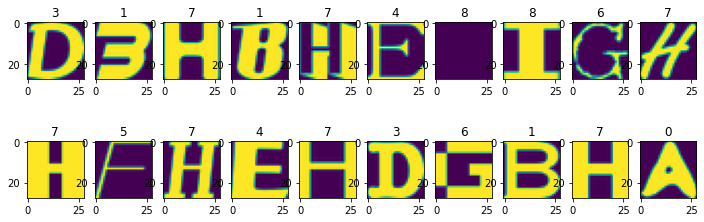

In [100]:
%matplotlib inline
plt.figure(figsize=[12, 4])
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[i].reshape([28, 28]))
    plt.title(str(y_train[i]))

In [101]:
model = nn.Sequential(
    nn.Linear(784, 50),   
    nn.Sigmoid(),    
    nn.Linear(50,10),
    nn.LogSoftmax(dim = 1)
    #nn.Softmax(dim = 1)       
)

In [102]:
ix = np.random.randint(0, len(X_train), 256)
x_batch = torch.tensor(X_train[ix], dtype=torch.float32)
#print (x_batch)
y_batch = torch.tensor(y_train[ix], dtype=torch.float32)
#print (y_batch)
#print (x_batch.size())
#print (y_batch.size())

In [103]:
history = []
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

for i in range(1000):

    # sample 256 random images
    ix = np.random.randint(0, len(X_train), 256)
    x_batch = torch.tensor(X_train[ix], dtype=torch.float32)
    y_batch = torch.tensor(y_train[ix], dtype=torch.float32)

    y_batch = y_batch.type(torch.LongTensor)

    # predict probabilities
    y_predicted =  model(x_batch)
    
    cross = nn.NLLLoss()
    loss = cross(y_predicted, y_batch)

    loss.backward()

    optimizer.step()

    optimizer.zero_grad()  


    history.append(loss.data.numpy())

    if i % 10 == 0:
        print("step #%i | mean loss = %.3f" % (i, np.mean(history[-10:])))

step #0 | mean loss = 2.321
step #10 | mean loss = 2.320
step #20 | mean loss = 2.300
step #30 | mean loss = 2.262
step #40 | mean loss = 2.247
step #50 | mean loss = 2.211
step #60 | mean loss = 2.181
step #70 | mean loss = 2.154
step #80 | mean loss = 2.127
step #90 | mean loss = 2.109
step #100 | mean loss = 2.078
step #110 | mean loss = 2.057
step #120 | mean loss = 2.034
step #130 | mean loss = 2.015
step #140 | mean loss = 1.986
step #150 | mean loss = 1.967
step #160 | mean loss = 1.956
step #170 | mean loss = 1.932
step #180 | mean loss = 1.911
step #190 | mean loss = 1.883
step #200 | mean loss = 1.870
step #210 | mean loss = 1.842
step #220 | mean loss = 1.824
step #230 | mean loss = 1.815
step #240 | mean loss = 1.796
step #250 | mean loss = 1.771
step #260 | mean loss = 1.755
step #270 | mean loss = 1.732
step #280 | mean loss = 1.712
step #290 | mean loss = 1.696
step #300 | mean loss = 1.686
step #310 | mean loss = 1.656
step #320 | mean loss = 1.634
step #330 | mean loss

In [104]:
predicted_y_test = model(torch.tensor(X_test))
print (y_test.shape)
print (predicted_y_test.size())
print (predicted_y_test[0])
print (y_test)


(4681,)
torch.Size([4681, 10])
tensor([-2.9429, -3.5216, -4.7833, -3.4022, -5.2880, -5.6976, -3.4951, -3.6661,
        -3.0872, -0.2664], grad_fn=<SelectBackward0>)
[9 3 0 ... 5 4 9]


In [105]:
answers = []
for array in predicted_y_test:
  answers.append(array.argmax().item())
print (answers)

[9, 3, 0, 3, 2, 4, 8, 9, 3, 0, 0, 2, 3, 3, 5, 4, 8, 5, 3, 5, 4, 8, 5, 1, 8, 8, 2, 9, 9, 6, 7, 1, 5, 5, 8, 5, 0, 1, 7, 1, 5, 1, 4, 6, 9, 1, 1, 7, 7, 2, 6, 5, 5, 1, 3, 7, 3, 5, 1, 5, 2, 9, 0, 3, 1, 7, 7, 4, 5, 7, 2, 6, 3, 6, 2, 0, 7, 3, 2, 2, 1, 3, 7, 2, 4, 3, 7, 1, 5, 7, 0, 5, 1, 8, 4, 6, 3, 5, 5, 4, 5, 2, 2, 6, 2, 7, 6, 8, 5, 4, 5, 5, 2, 4, 0, 3, 3, 6, 1, 3, 0, 8, 3, 1, 3, 9, 7, 6, 3, 0, 0, 9, 9, 8, 0, 6, 5, 4, 1, 2, 8, 0, 0, 8, 2, 5, 1, 2, 0, 7, 2, 9, 5, 8, 5, 0, 8, 9, 6, 7, 4, 5, 4, 2, 1, 4, 2, 4, 0, 5, 2, 9, 6, 2, 3, 4, 1, 5, 8, 5, 6, 9, 3, 4, 1, 8, 5, 4, 6, 0, 9, 0, 7, 7, 9, 3, 1, 2, 3, 0, 2, 6, 1, 6, 1, 7, 2, 5, 6, 9, 1, 2, 2, 8, 5, 6, 1, 2, 9, 1, 8, 9, 6, 4, 0, 3, 3, 1, 2, 5, 7, 3, 9, 5, 6, 9, 4, 8, 8, 9, 6, 2, 1, 7, 3, 1, 3, 2, 9, 6, 6, 5, 2, 1, 4, 3, 3, 8, 1, 1, 0, 6, 2, 4, 7, 1, 0, 3, 2, 6, 5, 7, 2, 9, 1, 0, 5, 1, 1, 9, 2, 0, 9, 7, 4, 8, 8, 9, 0, 1, 0, 5, 9, 4, 9, 6, 2, 6, 7, 6, 9, 4, 1, 9, 8, 2, 6, 8, 0, 4, 8, 2, 2, 3, 8, 1, 6, 0, 8, 2, 5, 8, 4, 4, 5, 1, 0, 2, 8, 7, 0, 4, 2, 

In [106]:
i = 0 
all_count = len(answers)
correct_count = 0
while i < len(answers):
  if answers[i] == y_test[i]:
    correct_count = correct_count +1
  i = i+1

print("Model Accuracy =", (correct_count/all_count))

Model Accuracy = 0.8517410809656056


# SPOILERS!

Recommended pipeline:

* Adapt logistic regression from seminar assignment to classify one letter against others (e.g. A vs the rest)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - Softmax (exp over sum of exps) can be implemented manually or as `nn.Softmax` (layer) or `F.softmax` (function)
  - Probably better to use STOCHASTIC gradient descent (minibatch) for greater speed
    - You can also try momentum/rmsprop/adawhatever
    - in which case the dataset should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (e.g. sigmoid) instead of softmax
  - You need to train both layers, not just the output layer :)
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
  - In ideal case this totals to 2 `torch.matmul`'s, 1 softmax and 1 ReLU/sigmoid
  - __Make sure this neural network works better than logistic regression!__

* Now's the time to try improving the network. Consider layers (size, neuron count), nonlinearities, optimization methods, initialization — whatever you want, but please avoid convolutions for now.

* If anything seems wrong, try going through one step of training and printing everything you compute.
* If you see NaNs midway through optimization, you can estimate $\log P(y \mid x)$ as `F.log_softmax(layer_before_softmax)`.

In [107]:

from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
for i in range(100):
    # sample 256 random images
    ix = np.random.randint(0, len(X_train), 256)
    x_batch = torch.tensor(X_train[ix], dtype=torch.float32)
    y_batch = torch.tensor(y_train[ix], dtype=torch.float32)

    logisticRegr.fit(x_batch, y_batch)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [108]:
logisticRegr.predict(X_test)

array([9., 3., 0., ..., 5., 4., 9.], dtype=float32)

In [109]:
score = logisticRegr.score(X_test, y_test)
print(score)

0.8297372356334116
